# Imports

In [1]:
%run potclass.ipynb

In [2]:
from math import log
from scipy.stats import linregress
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='Times New Roman')
import re
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.pyplot import * # plotting library
import numpy as np
import pylab as plt
import matplotlib.ticker as ticker
from matplotlib.pyplot import *
import pickle
from IPython.display import Latex
import imageio
from pandas import Series, DataFrame

# Main Functions

In [3]:
def PlotAndCompare(x, y, ths = [], xlbl = "x", ylbl = "y", title_i = ""):
    ax=matplotlib.pyplot.gca()

    plt.plot(x,y,'b.',lw=2, label = "Numerical")
    i = 0
    x = x[::10]
    clrs = ['red', 'orange', 'green']
    for th in ths:
        i += 1
        plt.plot(x, th(x), '.', color = clrs[i%3],label = "Theoretical " + str(i))

    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5)
    ax.tick_params('both', length=8, width=1.5, which='major')
    ax.tick_params('both', length=4, width=1.5, which='minor')
    ax.tick_params(direction='in')
    xlabel(xlbl,fontsize=30)
    ylabel(ylbl,fontsize=30)
    title(title_i, fontsize=30)
    xticks(size=25)
    yticks(size=25)
    legend()
    show()

In [4]:
def detect_crossing(Ltab, IPR):
    refL = Ltab[-1]
    return [np.argwhere(np.diff(np.sign(IPR[l]*np.sqrt(l) - IPR[refL]*np.sqrt(refL)))).flatten()[0]
            for l in Ltab[:-1]]

In [5]:
def compute_Vc(Vtab, crossing):
    minC = min(crossing)
    maxC = max(crossing)
    step = Vtab[1] - Vtab[0]
    error = max(2*step, (Vtab[maxC] - Vtab[minC])/2)
    Vc = (Vtab[maxC] + Vtab[minC] + step/2)/2
    display(Latex('$V_c = {0} \pm {1}$'.format(Vc, error)))
    return Vc, error

In [6]:
def plot_alpha(Vtab, Ltab, IPR, ymaxTab= [4, 4, 10, 50, 100]):
    alphaTab = [1/4, 1/3, 1/2, 2/3, 3/4]
    i = 0
    fig, axes = plt.subplots(3, 2,figsize=(15,15))
    for alpha in alphaTab:
        for l in Ltab:
            axes[i%3, i//3].plot(Vtab, IPR[l]*l**alpha, label='L = {}'.format(l))
        if ymaxTab != None: axes[i%3, i//3].set_ylim(0, ymaxTab[i])
        axes[i%3, i//3].legend()
        axes[i%3, i//3].set_title(r'Plot for $\alpha={}$'.format(alpha))
        axes[i%3, i//3].set_ylabel(r'$IPR_0 L^{\alpha}a^{1-\alpha}$')
        axes[i%3, i//3].set_xlabel(r'$V/E_r$')
        i += 1
    fig.show()

In [7]:
def fit_nu(Vtab, Vc, IPR, Ltab):
    def func(V, a, b):
        return a*V + b
    a_s = []
    b_s = []
    for l in Ltab:
        popt, pcov = curve_fit(func, np.log(Vtab-Vc), np.log(IPR[l]))
        perr = np.sqrt(np.diag(pcov))
        a_s.append(popt[0]+perr[0])
        a_s.append(popt[0]-perr[0])
        b_s.append(popt[1]+perr[1])
        b_s.append(popt[1]-perr[1])
    a_s = np.array(a_s)
    b_s = np.array(b_s)
    a = a_s.mean()
    b = b_s.mean()
    err_a = max(a_s.var(),-np.log(Vtab[1]-Vtab[0])*(Vtab[1]-Vtab[0]))
    err_b = max(b_s.var(), -np.log(Vtab[1]-Vtab[0])*(Vtab[1]-Vtab[0]))
    return a, b, err_a, err_b

In [8]:
def plot_nu(Vc, Ltab, f, minS = 1e-2, maxS = 1e-2, Delta = 1e-2):
    IPR_c = {}
    count = 0
    Vtab_c = np.linspace(Vc-minS,Vc+maxS,100)
    print(Vc-minS, Vc+maxS)
    res = (maxS + minS)/100
    for l in Ltab:
        IPR_c[l] = []
        count = 0
        for V in Vtab_c:
            if count%10 == 0:
                print(count, end = "%, ")
            Lattice2DInc = f(V, l)
            IPR_c[l].append(Lattice2DInc.IPR[0])
            count += 1
        print('100%')
    
    for l in Ltab:
        IPR_c[l] = np.array(IPR_c[l])
    
    crossing = detect_crossing(Ltab, IPR_c)
    print(crossing)
    Vc, err = compute_Vc(Vtab_c, crossing)
    
    idx1 = max(crossing) + int(Delta/res)
    print(idx1)
    
    Vtab_c = Vtab_c[idx1:]
    for l in Ltab:
        IPR_c[l] = IPR_c[l][idx1:]
    
    a,b,err_a,err_b = fit_nu(Vtab_c, Vc, IPR_c, Ltab)

    for l in Ltab:
        plt.loglog(Vtab_c-Vc, IPR_c[l], label = r'$L = {}$'.format(l))
    plt.loglog(Vtab_c-Vc, np.exp(a*np.log(Vtab_c-Vc) + b), label = r'$y = {0}x + {1}$'.format(round(a,3), round(b,3)))
    plt.xlabel(r'$(V-V_c)/E_r$')
    plt.ylabel(r'$IPR_0\times a$')
    plt.title(r'Log-log plot of the $IPR_0$ close to the phase transition.')
    plt.legend()
    plt.show()
    display(Latex('$\nu = {0} \pm {1}$'.format(a, err_a)))
    return a,b,err_a,err_b

In [9]:
def plot_nuprime(Ltab, f, Vc, Vmin, Vmax):
    IPR_c = {}
    count = 0
    Vtab_c = np.linspace(Vmin, Vmax,100)
    for l in Ltab:
        IPR_c[l] = []
        count = 0
        for V in Vtab_c:
            if count%10 == 0:
                print(count, end = "%, ")
            Lattice2DInc = f(V, l)
            IPR_c[l].append(Lattice2DInc.IPR[0])
            count += 1
        print('100%')
    
    for l in Ltab:
        IPR_c[l] = np.array(IPR_c[l])
    
    a,b,err_a,err_b = fit_nu(Vtab_c, Vc, IPR_c, Ltab)

    for l in Ltab:
        plt.loglog(Vtab_c, IPR_c[l], label = r'$L = {}$'.format(l))
    plt.loglog(Vtab_c-Vc, np.exp(a*np.log(Vtab_c-Vc) + b), label = r'$y = {0}x + {1}$'.format(round(a,3), round(b,3)))
    plt.xlabel(r'$(V-V_c)/E_r$')
    plt.ylabel(r'$IPR_0\times a$')
    plt.title(r'Log-log plot of the $IPR_0$ far from the phase transition.')
    plt.legend()
    plt.show()
    display(Latex("$\nu' = {0} \pm {1}$".format(a, err_a)))
    return a,b,err_a,err_b

In [10]:
def n(epsilon, Va, E, L):
    idx1 = np.argwhere(np.diff(np.sign(Va - E + epsilon /2))).flatten()
    if idx1.size > 0:
        idx1 = idx1[0]
    else:
        if E - epsilon/2 < Va[0]:
            idx1 = 0
        else:
            idx1 = len(Va)
    idx2 = np.argwhere(np.diff(np.sign(Va - E - epsilon/2))).flatten()
    if idx2.size > 0:
        idx2 = idx2[0]
    else:
        if E + epsilon/2 < Va[0]:
            idx2 = 0
        else:
            idx2 = len(Va)
    return (idx2 - idx1)/L

In [11]:
def NB(epsilon, Va, q, E1, E2, L, nb_points = 1000):
    Etab = np.linspace(E1, E2, nb_points)
    tot = 0
    for i in range(1, len(Etab)):
        E = (Etab[i] + Etab[i-1])/2
        tot += n(epsilon, Va, E, L)**q / epsilon
    return tot

In [12]:
def Bin(epsilon, func, start, delta, threshold = 0.05):
    tot = 0
    for i in range(epsilon):
        tot += (func[start + i] + func[start + i + 1])*delta/2
    if tot > threshold:
        return 1
    else:
        return 0

In [13]:
def N(func, epsTab, dx, threshold = 0.05):
    out = []
    for epsilon in epsTab:
        tmp = []
        for start in range(int(len(func)/epsilon)-1):
            tmp.append(Bin(epsilon, func, start, dx, threshold))
        out.append(sum(tmp)+1)
    return out

In [14]:
def BoxDim(func, epsTab, dx, threshold = 0.05):
    Neps = N(func, epsTab, dx, threshold)
    Neps = np.array(Neps)
    while Neps.any() == 1:
        print('recomp')
        if Neps[0] == 1:
            Neps = Neps[1:]
            new_eps = epsTab[-1]/10
            epsTab = epsTab[1:]
            epsTab.append(new_eps)
            Neps = np.append(Neps, N(func, [new_eps], dx, threshold))
        else:
            break
    def fit(eps, a, b):
        return a*eps + b
    popt, pcov = curve_fit(fit, np.log(epsTab), np.log(Neps))
    perr = np.sqrt(np.diag(pcov))
    return popt[0], perr[0]

In [15]:
testLattice = (pot.wVsin(4,(np.sqrt(5)-1)/2,1/10,600,6,6,"L","lnrhighbound", "nm_5000")) # The main calculation

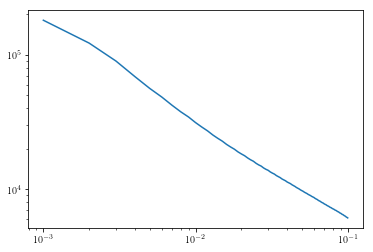

In [267]:
epsTab = np.linspace(1e-3, 1e-1, 100)
E1 = 9.5
E2 = 11
NBres = []
for eps in epsTab:
    res = NB(eps, testLattice.Va, 0.01, E1, E2, 600)
    NBres.append(res)

plt.loglog(epsTab, NBres)
plt.show()

In [268]:
popt, pcov = curve_fit(lambda x, a, b : a*x + b, np.log(epsTab), np.log(NBres))

In [269]:
popt

array([-0.73284477,  7.00173607])

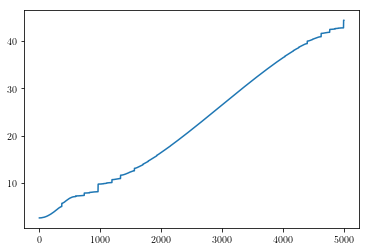

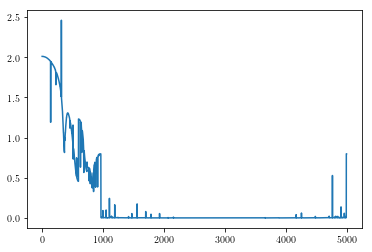

In [250]:
plt.plot(np.arange(len(testLattice.Va)), testLattice.Va)
plt.show()
plt.plot(np.arange(len(testLattice.Va)), testLattice.IPR)
plt.show()

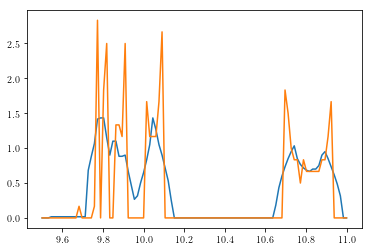

In [252]:
Etab = np.linspace(9.5,11,100)
ne = []
epsilon = 0.1
ne2 = []
epsilon2 = 0.01
for E in Etab:
    ne.append(n(epsilon, testLattice.Va, E, 600)/epsilon)
    ne2.append(n(epsilon2, testLattice.Va, E, 600)/epsilon2)
plt.plot(Etab, ne)
plt.plot(Etab, ne2)
plt.show()

# Free Particle

In [6]:
l=10.0
freePart=(pot.wVsin(0,2,1/12,l,0,0,"L","1")) # The main calculation 

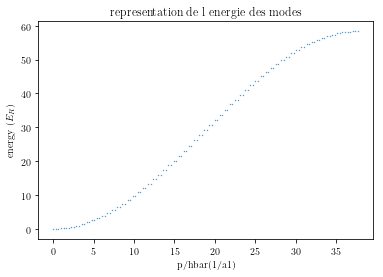

In [7]:
freePart.plotVA("p")

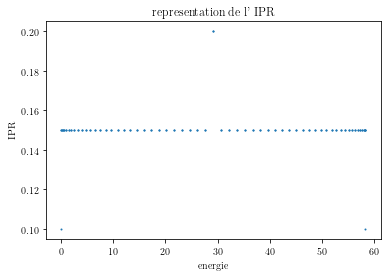

In [8]:
freePart.plotIPR("rev")

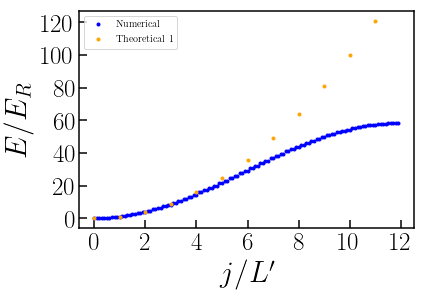

In [9]:
PlotAndCompare(np.array(range(120))/l, freePart.Va, [lambda x : x**2], r"$j/L'$", r"$E/E_R$")

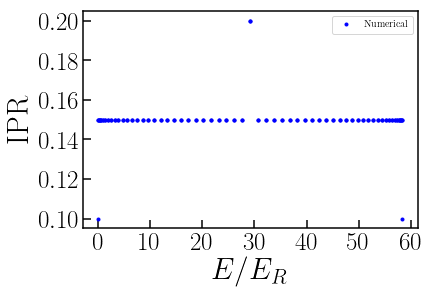

In [10]:
PlotAndCompare(freePart.Va, freePart.IPR, xlbl = r"$E/E_R$", ylbl = r"IPR")

# Harmonic Potential

In [11]:
l=20.0
HarmPart=(pot.wVharm(0,2,1/50,l,20,0,"L","1")) # The main calculation 
bound_n = 200

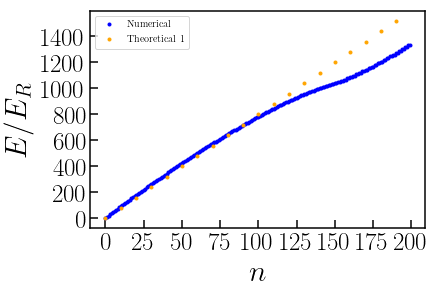

In [12]:
PlotAndCompare(np.array(range(bound_n)), HarmPart.Va[:bound_n], [lambda x : 8*x], r"$n$", r"$E/E_R$")

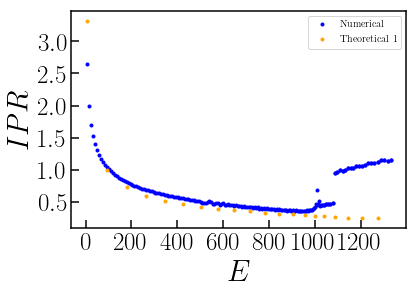

In [13]:
th = np.pi/np.sqrt(4*np.arange(1, bound_n+1, 10)) * HarmPart.V1n**(1/4)

PlotAndCompare(HarmPart.Va[:bound_n], HarmPart.IPR[:bound_n], [lambda x : th], r"$E$", r"$IPR$")

# Tight binding 1 Lattice, V1 = 20

In [14]:
l=100.0
Lattice1D =(pot.wVsin(0,2,1/50,l,20,0,"L","1")) # The main calculation

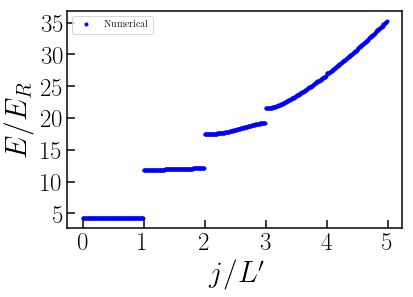

In [15]:
bound_n = 500
PlotAndCompare(np.array(range(bound_n))/l, Lattice1D.Va[:bound_n], [], r"$j/L'$", r"$E/E_R$")

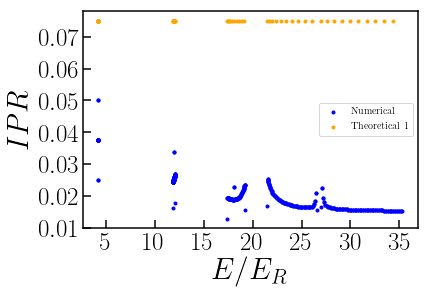

In [16]:
PlotAndCompare(Lattice1D.Va[:bound_n], Lattice1D.IPR[:bound_n], [lambda x : [0.075]*int(bound_n/10)], r"$E/E_R$", r"$IPR$")

# 2 Comensurable Lattices, r = 2, V1 = V2 = 4

In [17]:
l=100.0
Lattice2D =(pot.wVsin(0,2,1/50,l,4,4,"L","1")) # The main calculation
bound_n = 200

In [18]:
for i in range(0, len(Lattice2D.Va[:bound_n])-1):
    if abs(Lattice2D.Va[i] - Lattice2D.Va[i+1]) > 2:
        print(i, Lattice2D.Va[i])
        print(i+1, Lattice2D.Va[i+1])

#print((3.516894081123207 - np.min(Lattice2D.Va))/2)
#print((np.max(Lattice2D.Va[:bound_n]) - 5.955530802327432)/2)
#print(np.max(Lattice2D.Va[:bound_n])-5*0.79)

99 3.516894081123207
100 5.955530802327432


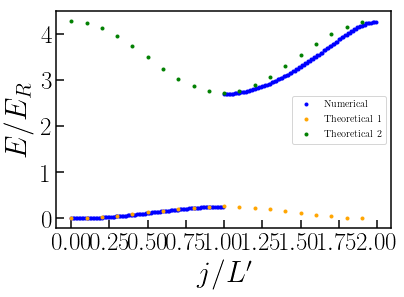

In [19]:
PlotAndCompare(np.array(range(bound_n))/l, Lattice2D.Va[:bound_n] - np.min(Lattice2D.Va), 
               [lambda x : 0.13-0.13*np.cos(l*np.pi/99 * x),
                lambda x : 3.5-0.78*np.cos(l*np.pi/99 * (x - 99/l))], 
               r"$j/L'$", r"$E/E_R$")

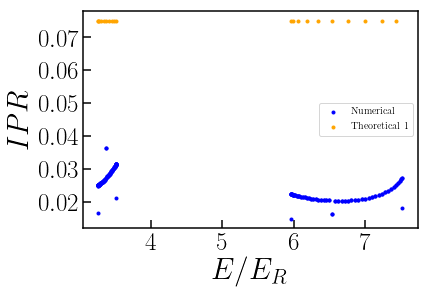

In [20]:
PlotAndCompare(Lattice2D.Va[:bound_n], Lattice2D.IPR[:bound_n], [lambda x : [0.075]*int(bound_n/10)], r"$E/E_R$", r"$IPR$")

# 1 Lattice Weak Binding V1 = 0.001

In [21]:
l=20.0
Lattice1D_weak =(pot.wVsin(0,2,1/50,l,0.001,0,"L","1")) # The main calculation
bound_n = 200

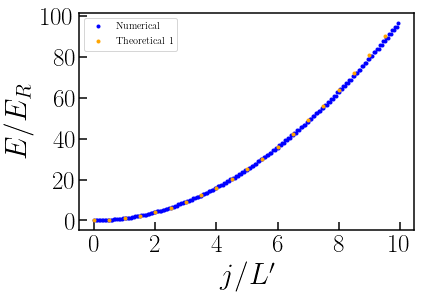

In [22]:
PlotAndCompare(np.array(range(bound_n))/l, Lattice1D_weak.Va[:bound_n], [lambda x : x**2], r"$j/L'$", r"$E/E_R$")

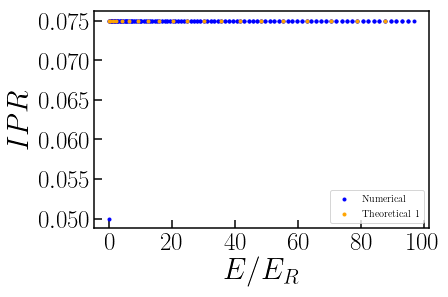

In [23]:
PlotAndCompare(Lattice1D_weak.Va[:bound_n], Lattice1D_weak.IPR[:bound_n], 
               [lambda x : [0.075]*int(bound_n/10)], r"$E/E_R$", r"$IPR$")

# Fitting of average model V = 10

In [24]:
l=40.0
Lattice1D_strong =(pot.wVsin(0,2,1/100,l,10,0,"L","1")) # The main calculation

In [25]:
bound_n = 1000

In [26]:
for i in range(0, len(Lattice1D_strong.Va[:bound_n])-1):
    if abs(Lattice1D_strong.Va[i] - Lattice1D_strong.Va[i+1]) > 2:
        print(i, Lattice1D_strong.Va[i])
        print(i+1, Lattice1D_strong.Va[i+1])

print((2.9232317496906544 - np.min(Lattice1D_strong.Va))/2)
print((8.490351680284576 - 7.494845572465477)/2)
print(8.490351680284576-5*0.5)

39 2.9232317496906544
40 7.494845572465477
79 8.490351680284576
80 10.611235825672477
866 455.93526330094693
867 457.9390683882592
868 457.9390683882594
869 459.9467561188851
870 459.9467561188851
871 461.9583215370167
872 461.95832153701684
873 463.97375967730113
874 463.9737596773015
875 465.99306556485305
876 465.9930655648531
877 468.0162342152661
878 468.01623421526614
879 470.04326063462463
880 470.04326063462474
881 472.0741398195166
882 472.0741398195166
883 474.1088667570446
884 474.10886675704467
885 476.14743642483893
886 476.1474364248391
887 478.18984379106905
888 478.18984379106917
889 480.23608381445575
890 480.2360838144558
891 482.2861514442835
892 482.2861514442837
893 484.34004162041276
894 484.3400416204129
895 486.3977492732919
896 486.39774927329194
897 488.4592693239695
898 488.45926932396964
899 490.524596684107
900 490.524596684107
901 492.5937262559902
902 492.59372625599036
903 494.6666529325426
904 494.6666529325428
905 496.743371597337
906 496.743371597337


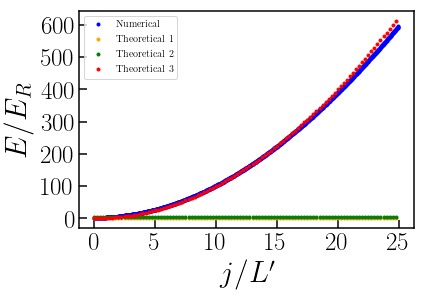

In [27]:
PlotAndCompare(np.array(range(bound_n))/l, Lattice1D_strong.Va[:bound_n]-np.min(Lattice1D_strong.Va), 
               [lambda x : 0.03-0.03*np.cos(l*np.pi/39 * x),
                lambda x : 5.2-0.50*np.cos(l*np.pi/39 * (x - 39/l)),
                lambda x : x**2], r"$j/L'$", r"$E/E_R$")

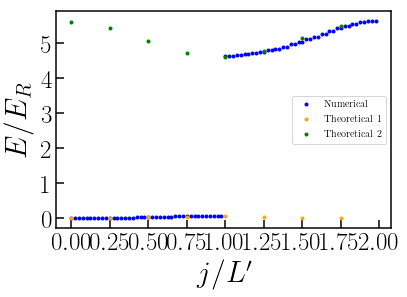

In [28]:
lbound = 80
PlotAndCompare(np.array(range(lbound))/l, Lattice1D_strong.Va[:lbound]-np.min(Lattice1D_strong.Va), 
               [lambda x : 0.03-0.03*np.cos(l*np.pi/39 * x),
                lambda x : 5.1-0.50*np.cos(l*np.pi/39 * (x - 39/l))], r"$j/L'$", r"$E/E_R$")

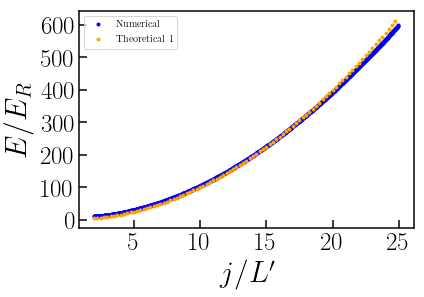

In [29]:
hbound = 920
PlotAndCompare(np.array(range(bound_n - hbound, bound_n))/l, Lattice1D_strong.Va[bound_n-hbound:bound_n], 
               [lambda x : x**2], r"$j/L'$", r"$E/E_R$")

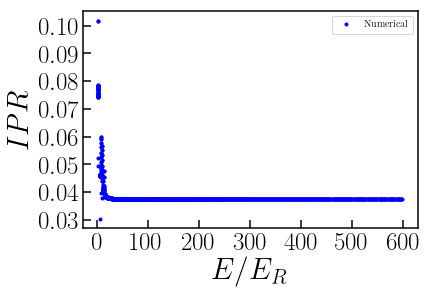

In [30]:
PlotAndCompare(Lattice1D_strong.Va[:bound_n], Lattice1D_strong.IPR[:bound_n], [], r"$E/E_R$", r"$IPR$")

# Quasi Periodic, V1 = 4, V2 = x

In [32]:
l=200.0
Vas = []
IPR = []
count = 0
for V2 in np.linspace(0, 1, 100):
    if count%10 == 0:
        print(count, end = "%, ")
    Lattice2DInc =(pot.wVsin(0,(np.sqrt(5)-1)/2,1/50,l,4,V2,"L","lnrhighbound", "nm_200")) # The main calculation
    bound_n = 200
    Vas.append(Lattice2DInc.Va)
    IPR.append(Lattice2DInc.IPR)
    count += 1
print('100%')

0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%


In [34]:
with open('./Results/QP_V1=4_V2=x_IPR=y', 'wb') as f:
    pickle.dump([Vas, IPR], f)

In [35]:
IPR = np.array(IPR)
print(IPR.shape)
Vas = np.array(Vas)
print(Vas.shape)
print(np.min(Vas))

(100, 200)
(100, 200)
1.544354159830268


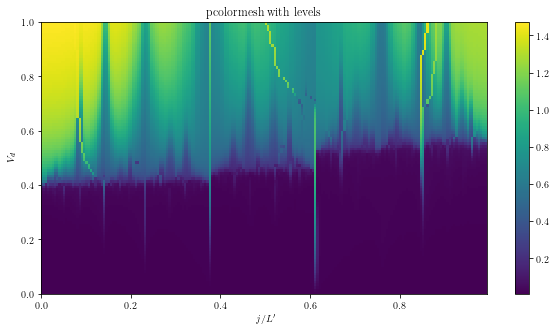

In [36]:
fig = plt.figure(figsize=(10,5))
ax0 = matplotlib.pyplot.gca()
im = ax0.pcolormesh(np.arange(200)/l, np.linspace(0, 1, 101), IPR)
fig.colorbar(im, ax=ax0)
ax0.set_title('pcolormesh with levels')
ax0.set_xlabel(r"$j/L'$")
ax0.set_ylabel(r"$V_d$")
plt.show()

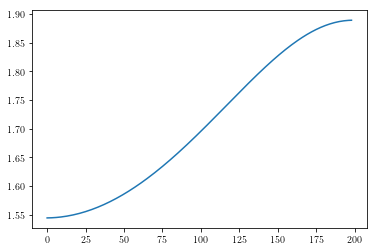

In [40]:
plt.plot(np.arange(199), Vas[0, :-1])

In [41]:
Vas = Vas[:, :-1]

In [42]:
print(np.sort(Vas.flatten()))

[1.54435416 1.54440332 1.54448525 ... 2.60522556 2.60557726 2.60564448]


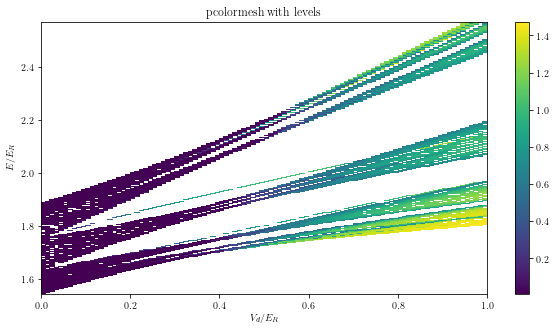

In [43]:
Etab = np.sort(Vas.flatten())[:-101]

IPRprime = [[np.nan]*101 for _ in range(len(Etab))]
i = 0
for E in Etab:
    j = 0
    for V in np.arange(100):
        if E in Vas[V]:
            #print(V, np.where(Vas[V] == E)[0][0])
            #print('ij:', i,j)
            IPRprime[i][j] = IPR[V, np.where(Vas[V] == E)[0][0]]
        j += 1
    i += 1
    
IPRprime = np.array(IPRprime)

fig = plt.figure(figsize=(10,5))
ax0 = matplotlib.pyplot.gca()
im = ax0.pcolormesh(np.linspace(0, 1, 101), Etab, IPRprime)
fig.colorbar(im, ax=ax0)
ax0.set_title('pcolormesh with levels')
ax0.set_xlabel(r"$V_d/E_R$")
ax0.set_ylabel(r"$E/E_R$")
plt.show()

# Quasi Periodic, V1 = V2 = x

In [103]:
IPR = {}
count = 0
Vtab = np.linspace(0,5,1000)
Ltab = [50, 200, 1000, 10000]
for l in Ltab:
    IPR[l] = []
    count = 0
    for V in Vtab:
        if count%100 == 0:
            print(count/10, end = "%, ")
        Lattice2DInc =(pot.wVsin(0,(np.sqrt(5)-1)/2,1/5,l,V,V,"L","lnrhighbound", "nm_2")) # The main calculation
        IPR[l].append(Lattice2DInc.IPR[0])
        count += 1
    print('100%')


0.0%, 10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100%
0.0%, 10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100%
0.0%, 10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100%
0.0%, 10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100%


In [48]:
with open('./Results/V1=V2=V_L=50,200,1000,10000,Vtab=x,IPR=y', 'wb') as f:
    pickle.dump([Vtab, IPR], f)

In [9]:
with open('./Results/V1=V2=V_L=50,200,1000,10000,Vtab=x,IPR=y', 'rb') as f:
    Vtab, IPR = pickle.load(f)
    Ltab = [50, 200, 1000, 10000]

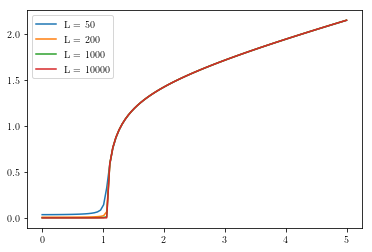

In [10]:
for l in Ltab:
    plt.plot(Vtab, IPR[l], label='L = {}'.format(l))
    
plt.legend()
plt.show()

In [151]:
IPR_restricted = {}
count = 0
Vtab_restricted = np.linspace(1.1,1.12,100)
Ltab = [50, 200, 1000, 10000]
for l in Ltab:
    IPR_restricted[l] = []
    count = 0
    for V in Vtab_restricted:
        if count%10 == 0:
            print(count, end = "%, ")
        Lattice2DInc =(pot.wVsin(0,(np.sqrt(5)-1)/2,1/20,l,V,V,"L","lnrhighbound", "nm_2")) # The main calculation
        IPR_restricted[l].append(Lattice2DInc.IPR[0])
        count += 1
    print('100%')

0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%
0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%
0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%
0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%


In [51]:
with open('./Results/V1=V2=V_restricted_L=50,200,1000,10000,Vtab=x,IPR=y', 'wb') as f:
    pickle.dump([Vtab_restricted, IPR_restricted], f)

In [303]:
with open('./Results/V1=V2=V_restricted_L=50,200,1000,10000,Vtab=x,IPR=y', 'rb') as f:
    Vtab_restricted, IPR_restricted = pickle.load(f)
    Ltab = [50, 200, 1000, 10000]

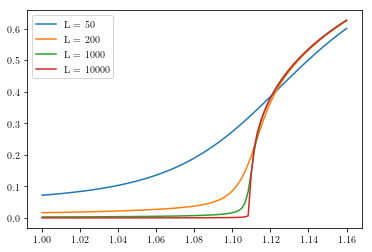

In [304]:
for l in Ltab:
    plt.plot(Vtab_restricted, IPR_restricted[l], label='L = {}'.format(l))
    
plt.legend()
plt.show()

In [155]:
%run potclass.ipynb
q = 3
IPRq_restricted = {}
count = 0
Vtab_restricted = np.linspace(1.1,1.12,100)
Ltab = [2000, 9000, 10000]
for l in Ltab:
    IPRq_restricted[l] = []
    count = 0
    for V in Vtab_restricted:
        if count%10 == 0:
            print(count, end = "%, ")
        Lattice2DInc =(pot.wVsin(0,(np.sqrt(5)-1)/2,1/20,l,V,V,"L","lnrhighbound", "nm_2")) # The main calculation
        Lattice2DInc.InversePartRatioq(3)
        IPRq_restricted[l].append(Lattice2DInc.IPRq[3][0])
        count += 1
    print('100%')

0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%
0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%
0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%


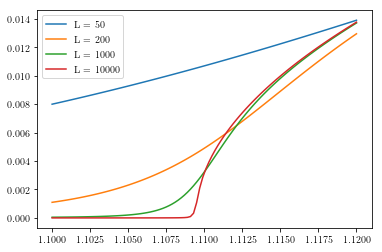

In [148]:
for l in Ltab:
    plt.plot(Vtab_restricted, IPRq_restricted[l], label='L = {}'.format(l))
    
plt.legend()
plt.show()

In [287]:
for l in Ltab:
    IPRq_restricted[l] = np.array(IPRq_restricted[l])

plot_alpha(Vtab_restricted, Ltab, IPRq_restricted, [0.1, 0.3, 1.5, 6, 12.5, 15])

KeyError: 50

In [152]:
crossing = detect_crossing(Ltab, IPRq_restricted)
print(crossing)
Vc, err = compute_Vc(Vtab_restricted, crossing)
print(Vc)

[47, 47, 47]


<IPython.core.display.Latex object>

1.1095454545454546


In [ ]:
a,b,err_a,err_b = plot_nu(Vc, Ltab, 
                          lambda V,l:pot.wVsin(0,(np.sqrt(5)-1)/2,1/20,l,V,V,"L","lnrhighbound", "nm_2"),
                         0.05, 0.05, 0.01)

In [305]:
for l in Ltab:
    IPR_restricted[l] = np.array(IPR_restricted[l])

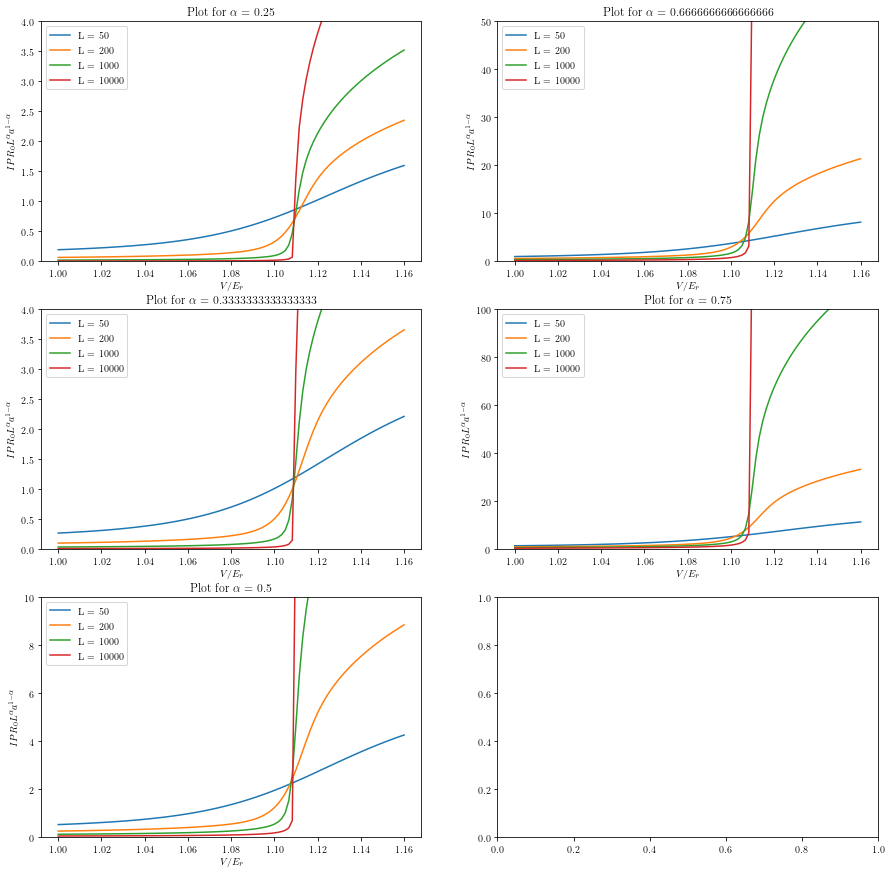

In [306]:
plot_alpha(Vtab_restricted, Ltab, IPR_restricted)

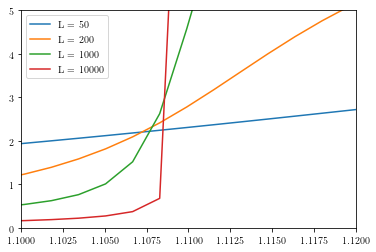

In [307]:
for l in Ltab:
    plt.plot(Vtab_restricted, IPR_restricted[l]*l**(1/2), label='L = {}'.format(l))
plt.xlim(1.1, 1.12)
plt.ylim(0, 5)
plt.legend()
plt.show()

In [308]:
crossing = detect_crossing(Ltab, IPR_restricted)
print(crossing)
Vc, err = compute_Vc(Vtab_restricted, crossing)
print(Vc)

[68, 68, 68]


<IPython.core.display.Latex object>

1.1103030303030303


1.063787878787879 1.163787878787879
0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%
0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%
0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%
0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%
[45, 45, 46]


<IPython.core.display.Latex object>

56


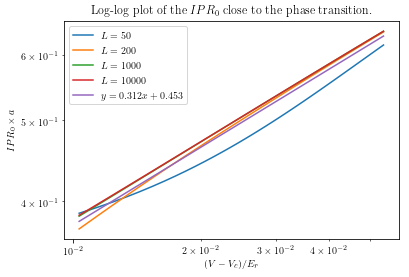

<IPython.core.display.Latex object>

In [278]:
a,b,err_a,err_b = plot_nu(Vc, Ltab, 
                          lambda V,l:pot.wVsin(0,(np.sqrt(5)-1)/2,1/20,l,V,V,"L","lnrhighbound", "nm_2"),
                         0.05, 0.05, 0.01)

0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%
0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%
0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%


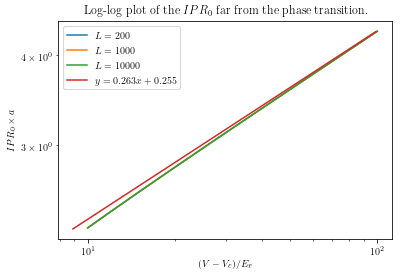

<IPython.core.display.Latex object>

In [312]:
a,b,err_a,err_b = plot_nuprime(Ltab[1:], lambda V,l:pot.wVsin(0,(np.sqrt(5)-1)/2,1/20,l,V,V,"L","lnrhighbound", "nm_2"),
                              Vc, 10, 100)

# Quasi Periodic, V1 = 8, V2 = x 

In [148]:
IPR_8 = {}
count = 0
Vtab_8 = np.linspace(0.1,0.2,100)
Ltab = [50, 200, 1000, 10000]
for l in Ltab:
    IPR_8[l] = []
    count = 0
    for V in Vtab_8:
        if count%10 == 0:
            print(count, end = "%, ")
        Lattice2DInc =(pot.wVsin(0,(np.sqrt(5)-1)/2,1/10,l,8,V,"L","lnrhighbound", "nm_100")) # The main calculation
        IPR_8[l].append(Lattice2DInc.IPR[0])
        count += 1
    print('100%')

0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%
0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%
0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%
0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%


In [149]:
with open('./Results/V1=8_L=50,200,1000,10000,V2=x,IPR=y', 'wb') as f:
    pickle.dump([Vtab_8, IPR_8], f)

In [288]:
with open('./Results/V1=8_L=50,200,1000,10000,V2=x,IPR=y', 'rb') as f:
    Vtab_8, IPR_8 = pickle.load(f)
    Ltab = [50, 200, 1000, 10000]

In [289]:
for l in Ltab:
    IPR_8[l] = np.array(IPR_8[l])

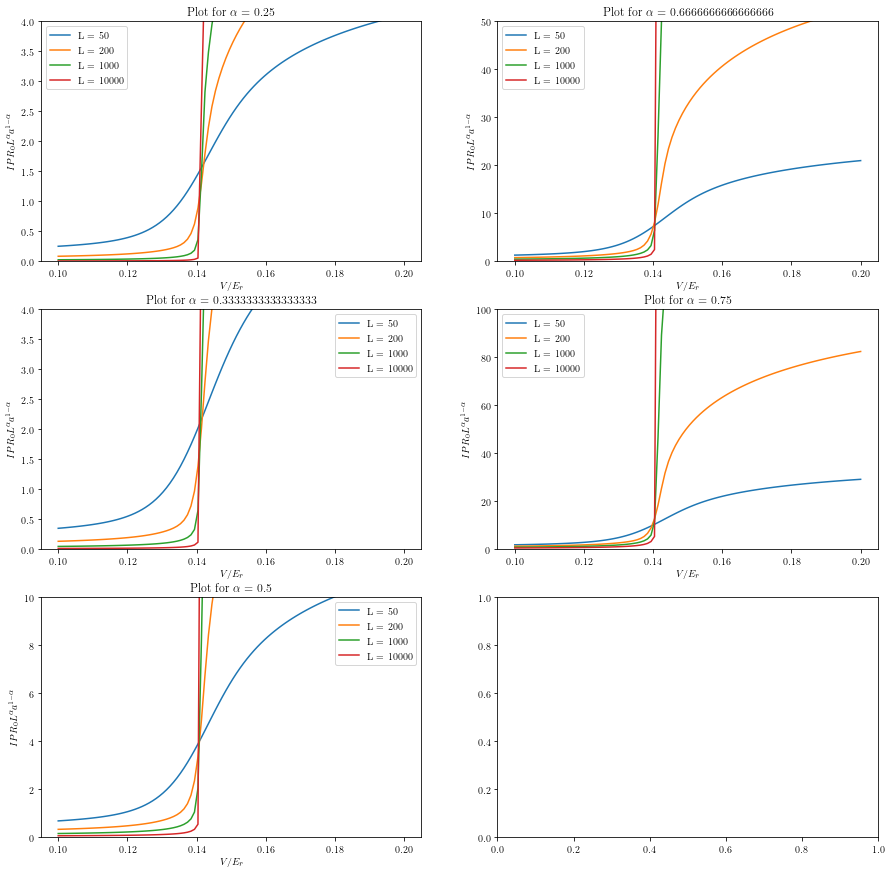

In [290]:
plot_alpha(Vtab_8, Ltab, IPR_8)

In [291]:
crossing = detect_crossing(Ltab, IPR_8)
print(crossing)
Vc, err = compute_Vc(Vtab_8, crossing)

[41, 41, 41]


<IPython.core.display.Latex object>

0.1366666666666667 0.1516666666666667
0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%
0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%
0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%
[25, 25]


<IPython.core.display.Latex object>

31


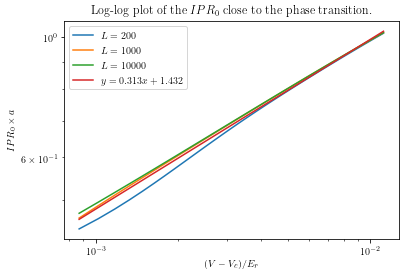

<IPython.core.display.Latex object>

In [292]:
a,b,err_a,err_b = plot_nu(Vc, Ltab[1:], 
                          lambda V,l:pot.wVsin(0,(np.sqrt(5)-1)/2,1/20,l,8,V,"L","lnrhighbound", "nm_2"),
                         0.005, 0.01, 0.001)

0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%
0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%
0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%


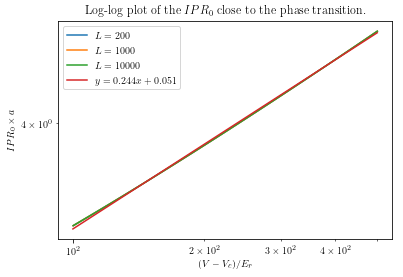

<IPython.core.display.Latex object>

In [297]:
a,b,err_a,err_b = plot_nuprime(Ltab[1:], lambda V,l:pot.wVsin(0,(np.sqrt(5)-1)/2,1/20,l,8,V,"L","lnrhighbound", "nm_2"),
                              Vc, 100, 500)

# Quasi Periodic, V1 = x, V2 = 7

In [137]:
IPR_7 = {}
count = 0
Vtab_7 = np.linspace(0,0.02,100)
Ltab = [50, 200, 1000, 10000]
for l in Ltab:
    IPR_7[l] = []
    count = 0
    for V in Vtab_7:
        if count%10 == 0:
            print(count, end = "%, ")
        Lattice2DInc =(pot.wVsin(0,(np.sqrt(5)-1)/2,1/10,l,V,7,"L","lnrhighbound", "nm_2")) # The main calculation
        IPR_7[l].append(Lattice2DInc.IPR[0])
        count += 1
    print('100%')

0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%
0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%
0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%
0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%


In [141]:
with open('./Results/V2=7_L=50,200,1000,10000,V1=x,IPR=y', 'wb') as f:
    pickle.dump([Vtab_7, IPR_7], f)

In [36]:
with open('./Results/V2=7_L=50,200,1000,10000,V1=x,IPR=y', 'rb') as f:
    Vtab_7, IPR_7 = pickle.load(f)
    Ltab = [50, 200, 1000, 10000]

In [37]:
for l in Ltab:
    IPR_7[l] = np.array(IPR_7[l])

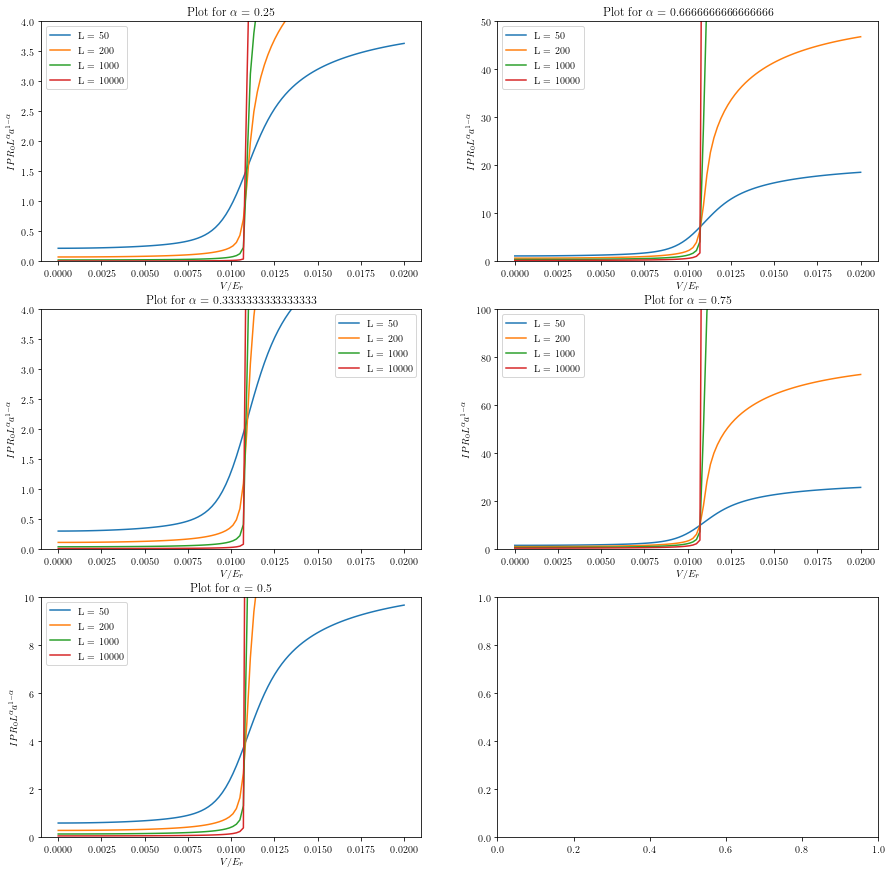

In [38]:
plot_alpha(Vtab_7, Ltab, IPR_7)

In [53]:
crossing = detect_crossing(Ltab, IPR_7)
print(crossing)
Vc, err = compute_Vc(Vtab_7, crossing)

[54, 54, 54]


<IPython.core.display.Latex object>

0.010207070707070706 0.011207070707070707
0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%
0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%
0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%
[26, 26]


<IPython.core.display.Latex object>

36


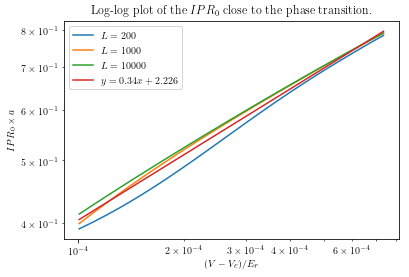

<IPython.core.display.Latex object>

In [40]:
a,b,err_a,err_b = plot_nu(Vc, Ltab[1:], 
                          lambda V,l:pot.wVsin(0,(np.sqrt(5)-1)/2,1/20,l,V,7,"L","lnrhighbound", "nm_2"),
                         0.0005, 0.0005, 0.0001)

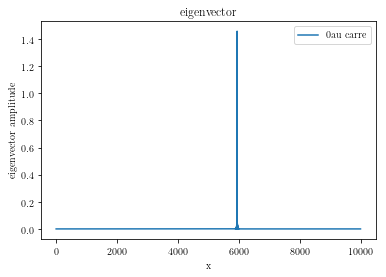

In [119]:
Lattice2DInc = (pot.wVsin(0,(np.sqrt(5)-1)/2,1/10,l,Vc+9*1e-3,7,"L","lnrhighbound", "nm_2")) # The main calculation
Lattice2DInc.plotVects([0],'p2')

# Quasi Periodic, AA limit, V1 = 30, V2 = x

In [69]:
IPR_30 = {}
count = 0
Vtab_30 = np.linspace(0,0.01,100)
Ltab = [50, 200, 1000, 10000]
for l in Ltab:
    IPR_30[l] = []
    count = 0
    for V in Vtab_30:
        if count%10 == 0:
            print(count, end = "%, ")
        Lattice2DInc =(pot.wVsin(0,(np.sqrt(5)-1)/2,1/20,l,30,V,"L","lnrhighbound", "nm_2")) # The main calculation
        IPR_30[l].append(Lattice2DInc.IPR[0])
        count += 1
    print('100%')

0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%
0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%
0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%
0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%


In [70]:
with open('./Results/V1=30_L=50,200,1000,10000,V2=x,IPR=y', 'wb') as f:
    pickle.dump([Vtab_30, IPR_30], f)

In [41]:
with open('./Results/V1=30_L=50,200,1000,10000,V2=x,IPR=y', 'rb') as f:
    Vtab_30, IPR_30 = pickle.load(f)
    Ltab = [50, 200, 1000, 10000]

In [42]:
for l in Ltab:
    IPR_30[l] = np.array(IPR_30[l])

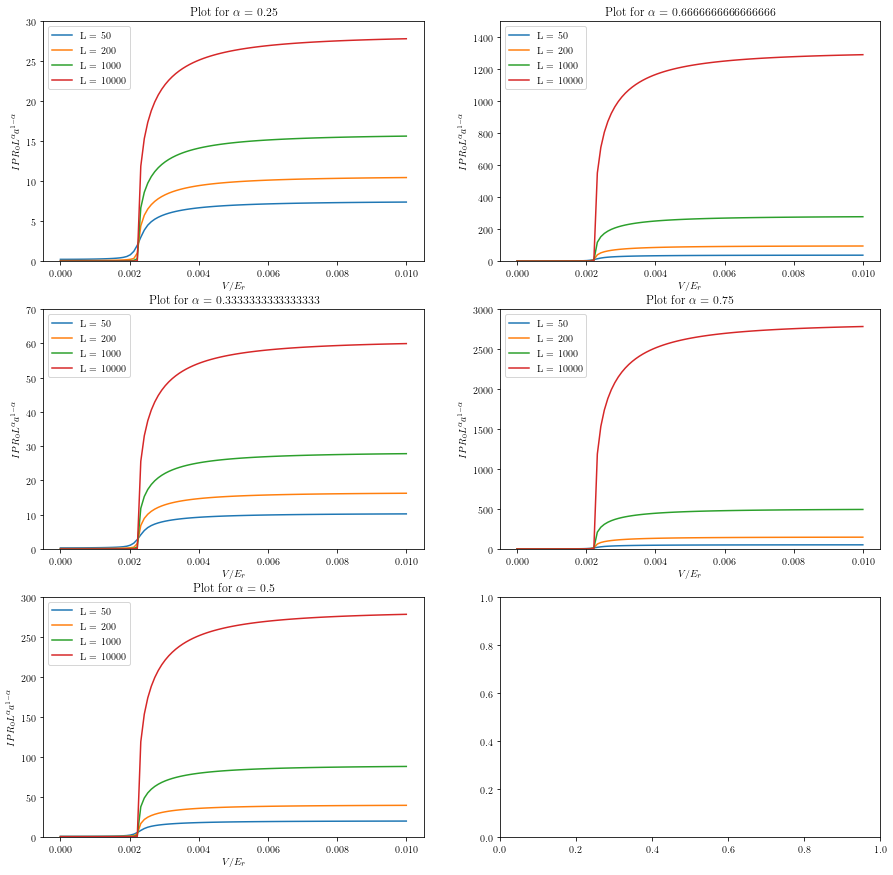

In [43]:
plot_alpha(Vtab_30, Ltab, IPR_30, ymaxTab = [30, 70, 300, 1500, 3000])

In [61]:
crossing = detect_crossing(Ltab, IPR_30)
print(crossing)
Vc, err = compute_Vc(Vtab_30, crossing)

[23, 23, 23]


<IPython.core.display.Latex object>

0.0021484848484848488 0.002349484848484849
0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%
0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%
0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%
[49, 50]


<IPython.core.display.Latex object>

54


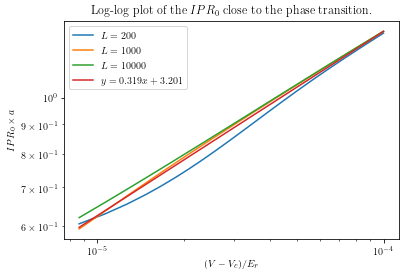

<IPython.core.display.Latex object>

In [135]:
a,b,err_a,err_b = plot_nu(Vc, Ltab[1:], 
                          lambda V,l:pot.wVsin(0,(np.sqrt(5)-1)/2,1/20,l,30,V,"L","lnrhighbound", "nm_2"),
                         2e-4, 1e-6, 1e-5)

0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%
0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%
0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%


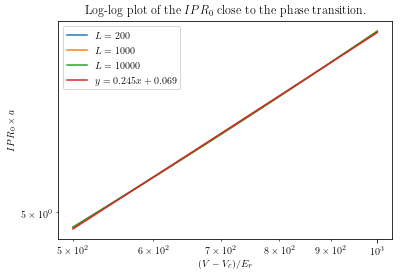

<IPython.core.display.Latex object>

In [301]:
a,b,err_a,err_b = plot_nuprime(Ltab[1:], lambda V,l:pot.wVsin(0,(np.sqrt(5)-1)/2,1/20,l,30,V,"L","lnrhighbound", "nm_2"),
                              Vc, 500, 1000)

# Theoretical Results

From theory we have that:
$$
\frac{V_2}{2}\exp\left(-r^2\sqrt{\frac{E_r}{V_1}}\right) = 8\frac{E_r}{\sqrt{\pi}}\left(\frac{V_1}{E_r}\right)^{3/4}\exp\left(-2\sqrt{\frac{V_1}{E_r}}\right)
$$

Then we know that:
$$
V_2 = 16\frac{E_r}{\sqrt{\pi}}\left(\frac{V_1}{E_r}\right)^{3/4}\exp\left(-2\sqrt{\frac{V_1}{E_r}}\right)\exp\left(r^2\sqrt{\frac{E_r}{V_1}}\right)
$$
And plugging this in we get that:

In [46]:
V1 = 30
r = (np.sqrt(5) - 1)/2
Vc_th = 16/np.sqrt(np.pi) * V1**(3/4)*np.exp(-2*np.sqrt(V1))*np.exp(r**2 * np.sqrt(1/V1))

In [62]:
print(Vc_th)

0.0021687762707659967


In [68]:
print(Vc-err, Vc+err)

0.002146464646464647 0.002550505050505051


# $\tau_q$, IPRq and fractality



In [ ]:
%run potclass.ipynb

def func(L, a, b):
    return a*L + b

LtabLog = np.linspace(np.log10(50), np.log10(10000), 1000)
Ltab = np.power(10, LtabLog)
Vtab = np.linspace(1.1, 1.12, 100)
tau = []
IPR = {}
err_tau = []
count = 0

for V in Vtab:
    if count%1 == 0:
        print('{}%, '.format(count), end='')
    IPR[V] = []
    for L in Ltab:
        Lattice = pot.wVsin(4,(np.sqrt(5)-1)/2,1/100,L,V,V,"L","lnrhighbound", "nm_2", "q_4")
        IPR[V].append(Lattice.IPR[0])
    popt, pcov = curve_fit(func, np.log(Ltab), np.log(IPR[V]))
    tau.append(-popt[0])
    err_tau.append(np.sqrt(np.diag(pcov))[0])
    count += 1

In [55]:
%run potclass.ipynb

def func(L, a, b):
    return a*L + b

LtabLog = np.linspace(np.log10(50), np.log10(10000), 1000)
Ltab = np.power(10, LtabLog)
Vtab = np.linspace(1.1, 1.12, 100)
tau = []
IPR = {}
err_tau = []
count = 0

for V in Vtab:
    if count%1 == 0:
        print('{}%, '.format(count), end='')
    IPR[V] = []
    for L in Ltab:
        Lattice = pot.wVsin(4,(np.sqrt(5)-1)/2,1/100,L,V,V,"L","lnrhighbound", "nm_2", "q_23")
        IPR[V].append(Lattice.IPR[0])
    popt, pcov = curve_fit(func, np.log(Ltab), np.log(IPR[V]))
    tau.append(-popt[0])
    err_tau.append(np.sqrt(np.diag(pcov))[0])
    count += 1


0%, 

KeyboardInterrupt: 

In [26]:
with open('./Results/FractalIPR', 'wb') as f:
    pickle.dump([Vtab, Ltab, IPR], f)

In [18]:
with open('./Results/FractalIPR', 'rb') as f:
    Vtab, Ltab, IPR = pickle.load(f)

In [51]:
tau = {0:[], 1:[], 2:[], 3:[], 4:[]}
err_tau = {0:[], 1:[], 2:[], 3:[], 4:[]}

def func(L, a, b):
    return a*L + b

for V in Vtab:
    '''
    for i in range(3,5):
        redL = Ltab[i*20:i*20 + 20]
        redIPR = IPR[V][i*20:i*20 + 20]
        popt, pcov = curve_fit(func, np.log(redL), np.log(redIPR))
        tau[i-3].append(-popt[0])
        err_tau[i-3].append(np.sqrt(np.diag(pcov))[0])
    popt, pcov = curve_fit(func, np.log(Ltab), np.log(IPR[V]))
    tau[4].append(-popt[0])
    err_tau[4].append(np.sqrt(np.diag(pcov))[0])
    popt, pcov = curve_fit(func, np.log(Ltab[50:]), np.log(IPR[V][50:]))
    tau[3].append(-popt[0])
    err_tau[3].append(np.sqrt(np.diag(pcov))[0])
    popt, pcov = curve_fit(func, np.log(Ltab[75:]), np.log(IPR[V][75:]))
    tau[2].append(-popt[0])
    err_tau[2].append(np.sqrt(np.diag(pcov))[0])
    '''
    for i in range(5):
        redL = Ltab[i*20:]
        redIPR = IPR[V][i*20:]
        popt, pcov = curve_fit(func, np.log(redL), np.log(redIPR))
        tau[i].append(-popt[0])
        err_tau[i].append(np.sqrt(np.diag(pcov))[0])

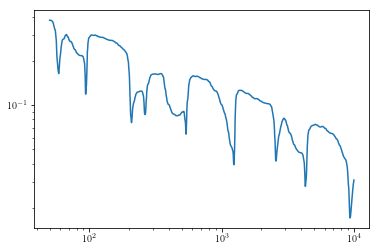

In [52]:
plt.loglog(Ltab, IPR[Vtab[57]])
plt.show()

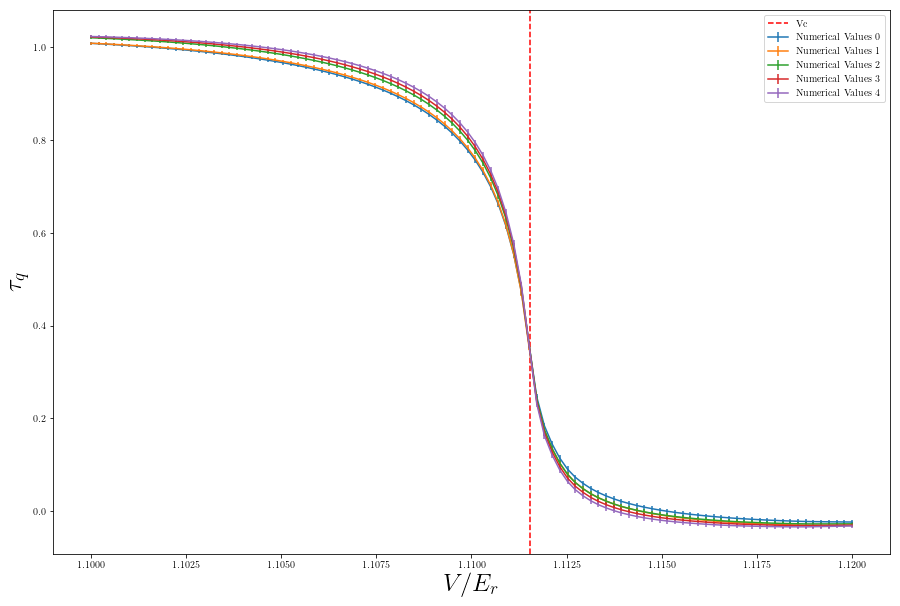

In [54]:
fig = plt.figure(figsize=(15,10))

for i in range(5):
    plt.errorbar(Vtab, tau[i], yerr = err_tau[i], label = 'Numerical Values {}'.format(i))

plt.axvline(x = 1.11154, color = 'r', linestyle = '--', label = 'Vc')
plt.legend()
plt.xlabel(r"$V/E_r$", size=25)
plt.ylabel(r"$\tau_q$", size =25)
plt.show()


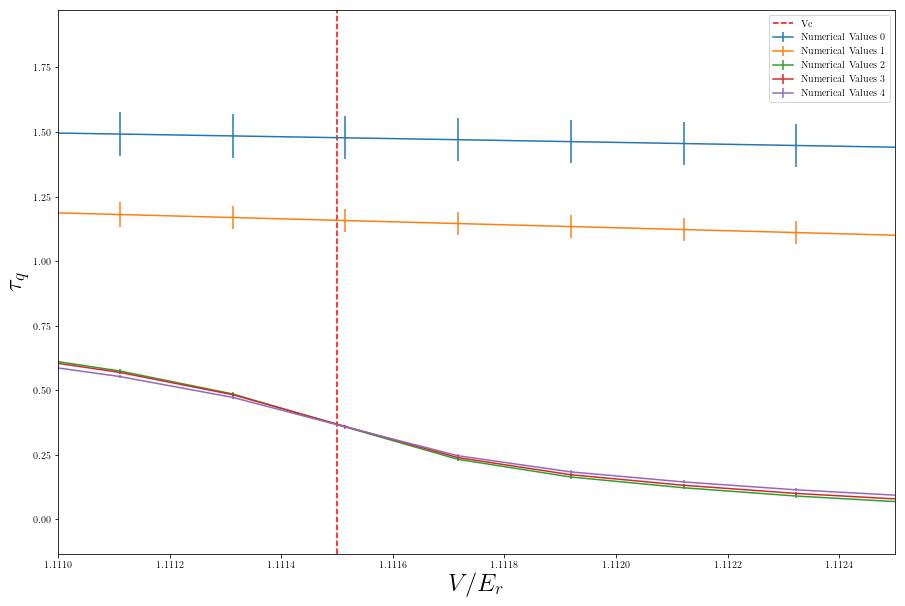

In [44]:
fig = plt.figure(figsize=(15,10))

for i in range(5):
    plt.errorbar(Vtab, tau[i], yerr = err_tau[i], label = 'Numerical Values {}'.format(i))

plt.axvline(x = 1.1115, color = 'r', linestyle = '--', label = 'Vc')
plt.xlim(1.111,1.1125)
plt.xlabel(r"$V/E_r$",size=25)
plt.ylabel(r"$\tau_q$",size=25)
plt.legend()
plt.show()

In [45]:
with open('./Results/tau2', 'wb') as f:
    pickle.dump([Vtab, tau, err_tau], f)

Mobility Edge $M$, $V_2=7$ varying $V_1$, with $V_1/E_r$ in range $0,10$.

In [ ]:
IPR_7 = {}
count = 0
Vtab_7 = np.linspace(0,0.02,100)
Ltab = [50, 200, 1000, 10000]
for l in Ltab:
    IPR_7[l] = []
    count = 0
    for V in Vtab_7:
        if count%10 == 0:
            print(count, end = "%, ")
        Lattice2DInc =(pot.wVsin(0,(np.sqrt(5)-1)/2,1/10,l,V,7,"L","lnrhighbound", "nm_2")) # The main calculation
        IPR_7[l].append(Lattice2DInc.IPR[0])
        count += 1
    print('100%')

In [ ]:
IPR2=[]
count=0
V1_tab=np.linspace(0,0.5,10)
L=200
Ltab=[50, 200, 1000, 10000]
dx=1/5
V_2=7

    
for V_1 in Vtab:
    if count%10==0:
        print(count, end="%, ")
    Lattice=(pot.wVsin(0,(np.sqrt(5)-1)/2,dx,L,V_1,V_2,"L","lnrhighbound", "nm_2"))
    IPR2.append(Lattice)
    count+=1
print("100%")








